In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from zoobot import label_metadata, schemas

In [2]:

df = pd.read_parquet(
    '/home/walml/repos/zoobot_private/gz_decals_volunteers_1_and_2_internal.parquet'
)

In [47]:
# df.columns.values

In [40]:
df['jpeg_loc']

0        /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
1        /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
2        /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
3        /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
4        /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
                               ...                        
92954    /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
92956    /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
92957    /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
92958    /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
92959    /media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...
Name: jpeg_loc, Length: 69574, dtype: object

In [3]:
question_answer_pairs = label_metadata.decals_dr12_pairs
dependencies = label_metadata.get_gz2_and_decals_dependencies(question_answer_pairs)
schema = schemas.Schema(question_answer_pairs, dependencies)

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar-dr12, indices 7 to 8, asked after disk-edge-on_no, index 4: (7, 8), bulge-size-dr12, indices 9 to 11, asked after disk-edge-on_no, index 4: (9, 11), how-rounded-dr12, indices 12 to 14, asked after smooth-or-featured_smooth, index 0: (12, 14), edge-on-bulge, indices 15 to 17, asked after disk-edge-on_yes, index 3: (15, 17), spiral-winding, indices 18 to 20, asked after has-spiral-arms_yes, index 5: (18, 20), spiral-arm-count-dr12, indices 21 to 25, asked after has-spiral-arms_yes, index 5: (21, 25), merging-dr12, indices 26 to 29, asked after None: (26, 29)}


In [4]:
[a.text for a in schema.get_question('how-rounded-dr12').answers]

['how-rounded-dr12_completely',
 'how-rounded-dr12_in-between',
 'how-rounded-dr12_cigar-shaped']

In [5]:
# create some sensible text descriptions, then aggregate until classes look good

In [18]:
def get_question_semantic_label(galaxy, question, min_relevance_threshold=0.5, min_confidence_threshold = 0.5):
    
    if question.asked_after is not None:
        # i.e. must have at least 34 * 0.5 answers (17) and have at least half of volunteers gone down this path
        has_enough_answers = galaxy[question.asked_after.text.replace('-dr12', '')] > galaxy['smooth-or-featured_total-votes'] * min_relevance_threshold
        if not has_enough_answers:
            return '-'
    
    answer_cols = [a.text.replace('-dr12', '')  for a in question.answers]
    highest_conf_answer = np.argmax(galaxy[answer_cols])
    if galaxy[answer_cols[highest_conf_answer] + '_fraction'] > min_confidence_threshold:
        return answer_cols[highest_conf_answer]
    else:
        return 'unclear'


In [19]:
galaxy = df.iloc[0]

for question in schema.questions:
    print(question.text, get_question_semantic_label(galaxy, question))


smooth-or-featured unclear
disk-edge-on -
has-spiral-arms -
bar-dr12 -
bulge-size-dr12 -
how-rounded-dr12 -
edge-on-bulge -
spiral-winding -
spiral-arm-count-dr12 -
merging-dr12 merging_neither


In [20]:
schema.questions

[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar-dr12, indices 7 to 8, asked after disk-edge-on_no, index 4,
 bulge-size-dr12, indices 9 to 11, asked after disk-edge-on_no, index 4,
 how-rounded-dr12, indices 12 to 14, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 15 to 17, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 18 to 20, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count-dr12, indices 21 to 25, asked after has-spiral-arms_yes, index 5,
 merging-dr12, indices 26 to 29, asked after None]

In [27]:
df = df[df['smooth-or-featured_total-votes'] > 34]
print(len(df))

sample = df.sample(3000).reset_index(drop=True)
# sample = df.reset_index(drop=True)

for question in schema.questions:
    sample[question.text.replace('-dr12', '') + '_semantic'] = sample.apply(lambda x: get_question_semantic_label(x, question), axis=1)

69574


In [28]:
sample['smooth-or-featured_semantic'].value_counts()

smooth-or-featured_smooth              47163
smooth-or-featured_featured-or-disk    15446
unclear                                 6217
smooth-or-featured_artifact              748
Name: smooth-or-featured_semantic, dtype: int64

In [29]:
sample['has-spiral-arms_semantic'].value_counts()

-                      59106
has-spiral-arms_yes     9111
has-spiral-arms_no      1285
unclear                   72
Name: has-spiral-arms_semantic, dtype: int64

In [30]:
key_questions = ['smooth-or-featured', 'how-rounded', 'disk-edge-on', 'has-spiral-arms', 'bar']

sample['temp_semantic_label'] = sample.apply(lambda galaxy: ' '.join(galaxy[[col + '_semantic' for col in key_questions]]), axis=1)

sample['temp_semantic_label'].value_counts()[:20]

smooth-or-featured_smooth how-rounded_in-between - - -                               22988
smooth-or-featured_smooth how-rounded_completely - - -                               18342
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_no      7201
unclear - - - -                                                                       6217
smooth-or-featured_smooth how-rounded_cigar-shaped - - -                              4897
smooth-or-featured_featured-or-disk - disk-edge-on_yes - -                            2815
smooth-or-featured_featured-or-disk - disk-edge-on_no - -                             2111
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_yes     1757
smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_no       1058
smooth-or-featured_smooth unclear - - -                                                936
smooth-or-featured_artifact - - - -                                                    748

In [31]:
# in-between, completely, cigar-shaped: plenty of galaxies. Remove in-between?
# face-on unbarred spirals
# face-on barred spirals
# edge-on disks
# featured but no spiral arms, no bar?

In [32]:
semantic_to_summary = {
    'smooth-or-featured_smooth how-rounded_completely - - -': 'smooth_round',
    'smooth-or-featured_smooth how-rounded_cigar-shaped - - -': 'smooth_cigar',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_no': 'unbarred_spiral',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_yes bar_yes': 'barred_spiral',
    'smooth-or-featured_featured-or-disk - disk-edge-on_yes - -': 'edge_on_disk',
    'smooth-or-featured_featured-or-disk - disk-edge-on_no has-spiral-arms_no bar_no': 'featured_without_bar_or_spiral'
}
sample['summary'] = sample['temp_semantic_label'].apply(lambda x: semantic_to_summary.get(x, None))

sample['summary'].value_counts()

smooth_round                      18342
unbarred_spiral                    7201
smooth_cigar                       4897
edge_on_disk                       2815
barred_spiral                      1757
featured_without_bar_or_spiral     1058
Name: summary, dtype: int64

In [52]:
sample[['iauname', 'summary']].sort_values('iauname').to_parquet('/home/walml/repos/galaxy_mnist/reproduce/latest_labels.parquet', index=False)

In [41]:
def show_galaxies(df, start_index=0, crop_size=50):
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))
    all_axes = [ax for row in axes for ax in row]
    for n in range(10):
        galaxy = df.iloc[start_index+n]
        im = Image.open(galaxy['jpeg_loc']).crop((50, 50, 424-crop_size, 424-crop_size))
        ax = all_axes[n]
        ax.imshow(im)
        ax.axis(False)
        # ax.text(30, 30, 'R. Tags: {:.0f}'.format(galaxy['tag_count']), color='r')
        # ax.text(30, 60, 'Feat: {:.2f}'.format(galaxy['smooth-or-featured_featured-or-disk_fraction']), color='r')
        # ax.text(30, 90, 'Edge: {:.2f}'.format(1-galaxy['disk-edge-on_no_fraction']), color='r')
    fig.tight_layout()

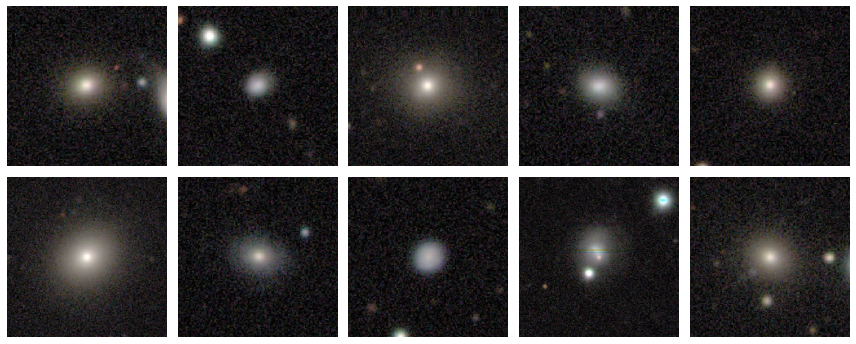

In [42]:
show_galaxies(sample.query('summary == "smooth_round"'))

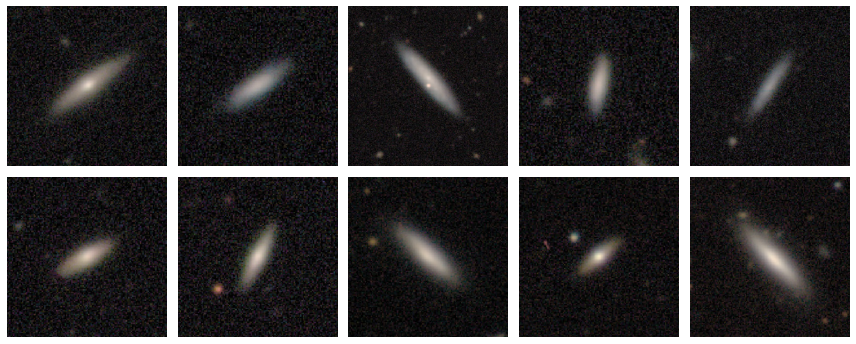

In [43]:
show_galaxies(sample.query('summary == "smooth_cigar"'))

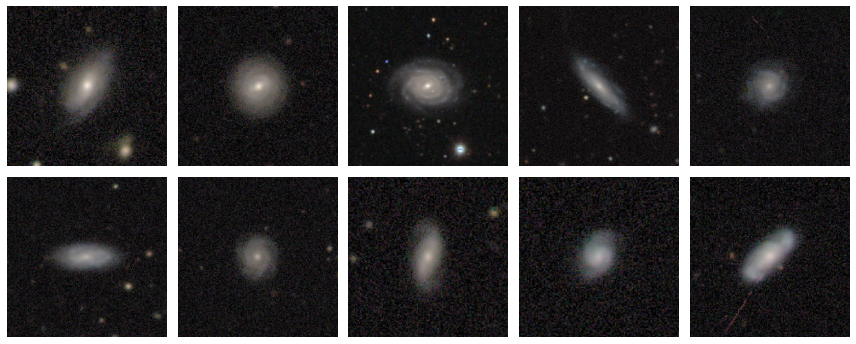

In [44]:
show_galaxies(sample.query('summary == "unbarred_spiral"'))

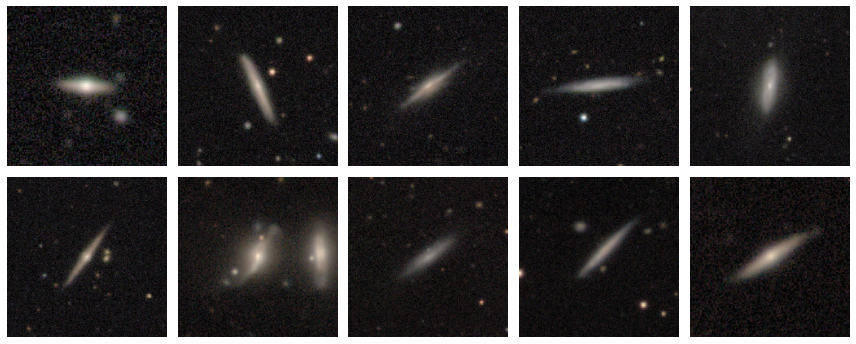

In [46]:
show_galaxies(sample.query('summary == "edge_on_disk"'))
# with the four classes above, 12,000 galaxies in balanced dataset

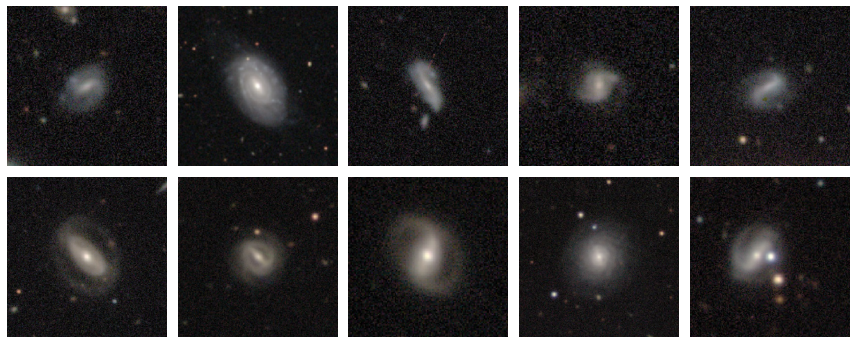

In [48]:
# 1700 of this class (so 8000ish total)
# not that different from spirals, maybe tricky
show_galaxies(sample.query('summary == "barred_spiral"'))

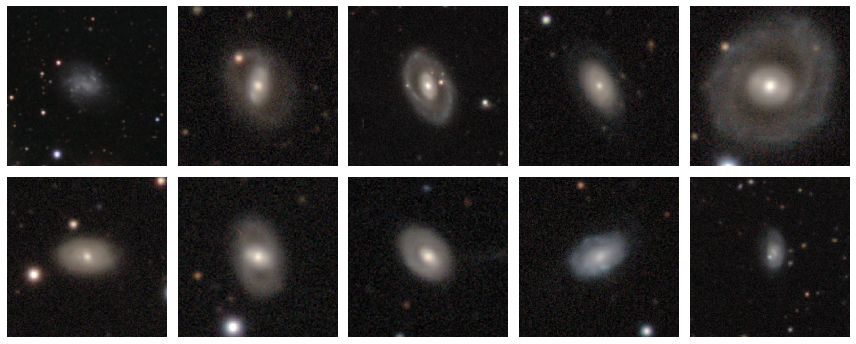

In [50]:
# visually very interesting, but only 1000 (so 6000 total for dataset)
show_galaxies(sample.query('summary == "featured_without_bar_or_spiral"'))